![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with Permutation Feature Importance

In this Notebook we will demonstrate how to use the permutation importance method and interpret its results.

--------


### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/permutation_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import permutation_importance

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

## The California Housing Dataset: Data Loading and Model Training

Let's use the California housing data set. The data pertains to the house prices found in a given California district and some summary statistics about them based on the 1990 census data.

In [3]:
calif_house_data = fetch_california_housing()

Now, let's have a look at the description of the dataset:

In [4]:
print(calif_house_data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Let's see how many samples and features we have in the dataset:

In [5]:
print(calif_house_data['feature_names'])
print('\n')
print('Features - # rows, # columns:', calif_house_data['data'].shape)
print('\n')
print('Target variable - # rows:', calif_house_data['target'].shape)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Features - # rows, # columns: (20640, 8)


Target variable - # rows: (20640,)


The data set has 20640 observations, 8 features, and 1 target variable.
The target variable *price* is continuous and given in 100.000 $, so we can predict it using the other available features with a regression model of our choice.

Let's put all of our data into a data frame.

In [6]:
df = pd.DataFrame(calif_house_data['data'])
df.columns = calif_house_data['feature_names']
df['price'] = calif_house_data['target']

# we need the column names later on
feat_cols = calif_house_data['feature_names']
target_col = "price"

# pd.set_option('display.max_columns', 12)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Let's have a quick look of the structure of the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


For the sake of runtime we limit ourselves to only the first 2000 samples.

In [9]:
df = df[:2000]

We will split parts of the data, so the model can not use all the available information for training. That way, we can also check performance and interpretation results on previously unseen data, mirroring the most probable practical use case.

In [10]:
# split off the test data
df_train, df_test = train_test_split(df, train_size=0.75, random_state=seed)
print(df_train.shape, df_test.shape)

(1500, 9) (500, 9)


We'll create a Kernel ridge regression model with an RBF kernel to predict our *price* target variable from the other features, after they have been properly rescaled to each have zero mean and unit standard deviation.  
Don't worry for now if you are not familiar with the model. It is just meant as a protoype of a model that is not straightforward to interpret.

In [11]:
pipe = Pipeline([
    ("preprocessing", StandardScaler()),
    ("model", KernelRidge(kernel="rbf"))
])

pipe.fit(df_train[feat_cols], df_train[target_col])

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('model', KernelRidge(kernel='rbf'))])

Now that the model is fit, let's check its performance as measured by the R^2 metric for both the training and the validation data. The closer this value is to one, the better our model explains the data.

In [12]:
# is the model performing reasonably on the training data?
print('Model Performance on training data: {}'.format(pipe.score(df_train[feat_cols], df_train[target_col])))

# is the model performing reasonably on the test data?
print('Model Performance on test data: {}'.format(pipe.score(df_test[feat_cols], df_test[target_col])))

Model Performance on training data: 0.8051966649446614
Model Performance on test data: 0.720510163411604


As we are not so much concerned with the performance of the model, we will just keep it at that and do not try to improve further. Now, that we trained a regression model which predicts the prices relatively well but might be a bit hard to interpet directly, we can make use of permutation importance to help us out.

**Note: you should keep in mind that interpreting a low performing model might lead to misleading conclusions.**

## What does my model actually think is important in the data?

### Permutation Feature Importance

We will try to get insights into which features are important by carrying out a method called **Permutation feature importance**. The following explanation of the approach is taken directly from the [scikit_learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance):

"*Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature*"

We prepared a small video lecture for you to help you understand how Permutation Feature Importance works.

In [13]:
from IPython.display import VimeoVideo

VimeoVideo("745319412?h=1e5bd15ff7", width=800, height=600)

To summarize, Permutation Feature Importance for a dataset of your choice works in the following way:

First, an already trained model predicts outputs and computes a performance measure for our dataset. This will serve as baseline performance.

Then, we carry out the following steps for each feature (potentially repeated multiple times):

1) We permute the features value across the dataset, essentially messing up any connection between the label and this feature.  
2) We predict outputs and compute the performance measure based on our dataset with the permuted feature.  
3) We compare the performance measure with the baseline performance.  
4) We use the difference between baseline performance and permuted performance as an indicator of the importance of the feature.  

If both performances are similar, the messed up feature did not lead to a decrease in model performance, indicating that the model did not rely heavily on the feature, hence assigning low importance. 
On the other hand, if the performance of the data with the permuted feature is much worse than the baseline performance, this shows that the model highly depended on the feature to produce good scores.

**Note:** this method is a **global** method which means that it does only provide explanations for a full dataset, but not for individual samples.

Now lets use Permutation Feature Importance to get some insights into the Kernel Ridge regression model we trained above. For measuring performance we use the mean absolute error metric. Since scikit learn expects a score that is larger for better performing models, we have to use the negated value instead.

In [14]:
from sklearn.metrics import get_scorer
scorer = get_scorer("neg_mean_absolute_error")

We use scikit learn permutation importance to evaluate the performance of each feature for us. 10 repetitions of permutation are done for each feature to get more reliable results.

In [15]:
explanation_train = permutation_importance(
    pipe,
    X=df_train[feat_cols],
    y=df_train[target_col],
    n_repeats=10,
    random_state=seed,
    scoring=scorer
)

explanation_train["feature"] = feat_cols

We will now plot bar histograms for visualizing the importance of each feature as obtained by the mean over the 10 repetitions. To judge variability, we plot the standard deviations of the feature importances as well.

In [16]:
def plot_explanation(explanation):
    explanation_df = pd.DataFrame({k: v for k, v in explanation.items() if k != "importances"}).sort_values(
        by="importances_mean", ascending=True)

    f, ax = plt.subplots(1, 1, figsize=(9, 7))
    explanation_df.plot(kind='barh', ax=ax)
    plt.title('Permutation importances')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)

    if "feature" in explanation_df:
        _ = ax.set_yticklabels(explanation_df["feature"])

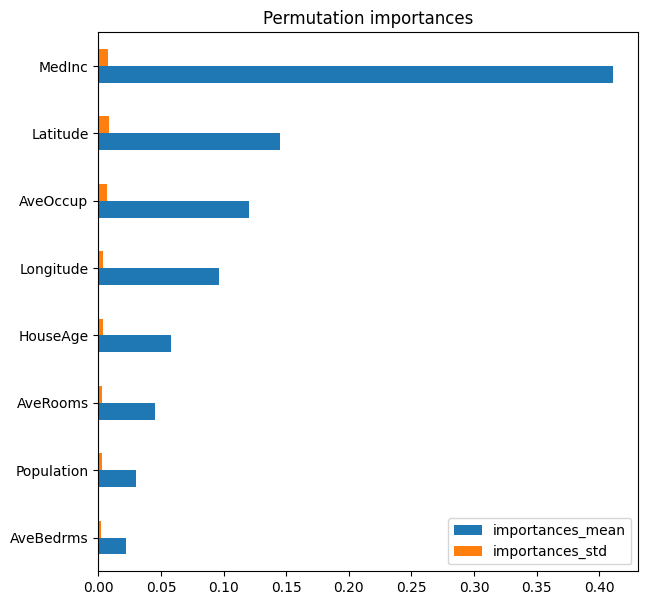

In [17]:
plot_explanation(explanation_train)

We are not restricted to obtain feature importances of the same data set that we used to train the model. Instead we could use the same approach to identify the most important features in the test set.

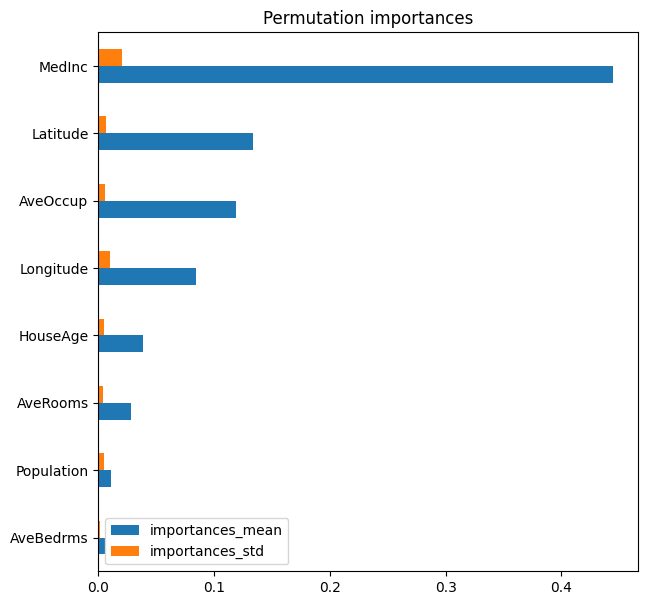

In [18]:
explanation_test = permutation_importance(
    pipe,
    X=df_test[feat_cols],
    y=df_test[target_col],
    n_repeats=10,
    random_state=seed,
    scoring=scorer)

explanation_test["feature"] = feat_cols

plot_explanation(explanation_test)

It seems that for both datasets, largely the same features are identified as important, which is a reassuring thing.
Features with the largest importance score are the ones whose score is most decreased when the feature is permuted, indicating high relevance for prediction of the target.

Note however, that this agreement of important features between training and testing datasets is not guaranteed.
In such cases, it is not straightforward to decide on the "truly important" features for the model.

### A word of warning (also taken from the sklearn documentation)

"*When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.*"

Let's create toy data of multiple features of which the first two are highly correlated but only one
of them will be used for computing our label.

In [19]:
corr = 0.9
n_vars = 5

means = np.array([i*5 for i in range(n_vars)])
cov = np.diag(np.ones(n_vars))
cov[0, 1] = corr
cov[1, 0] = corr

samples = np.random.multivariate_normal(means, cov, size=2000)
df = pd.DataFrame(samples)

<AxesSubplot:ylabel='Density'>

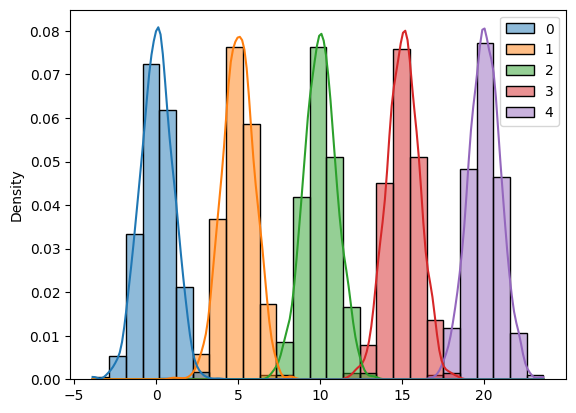

In [20]:
sns.histplot(data=df, kde=True, stat="density")

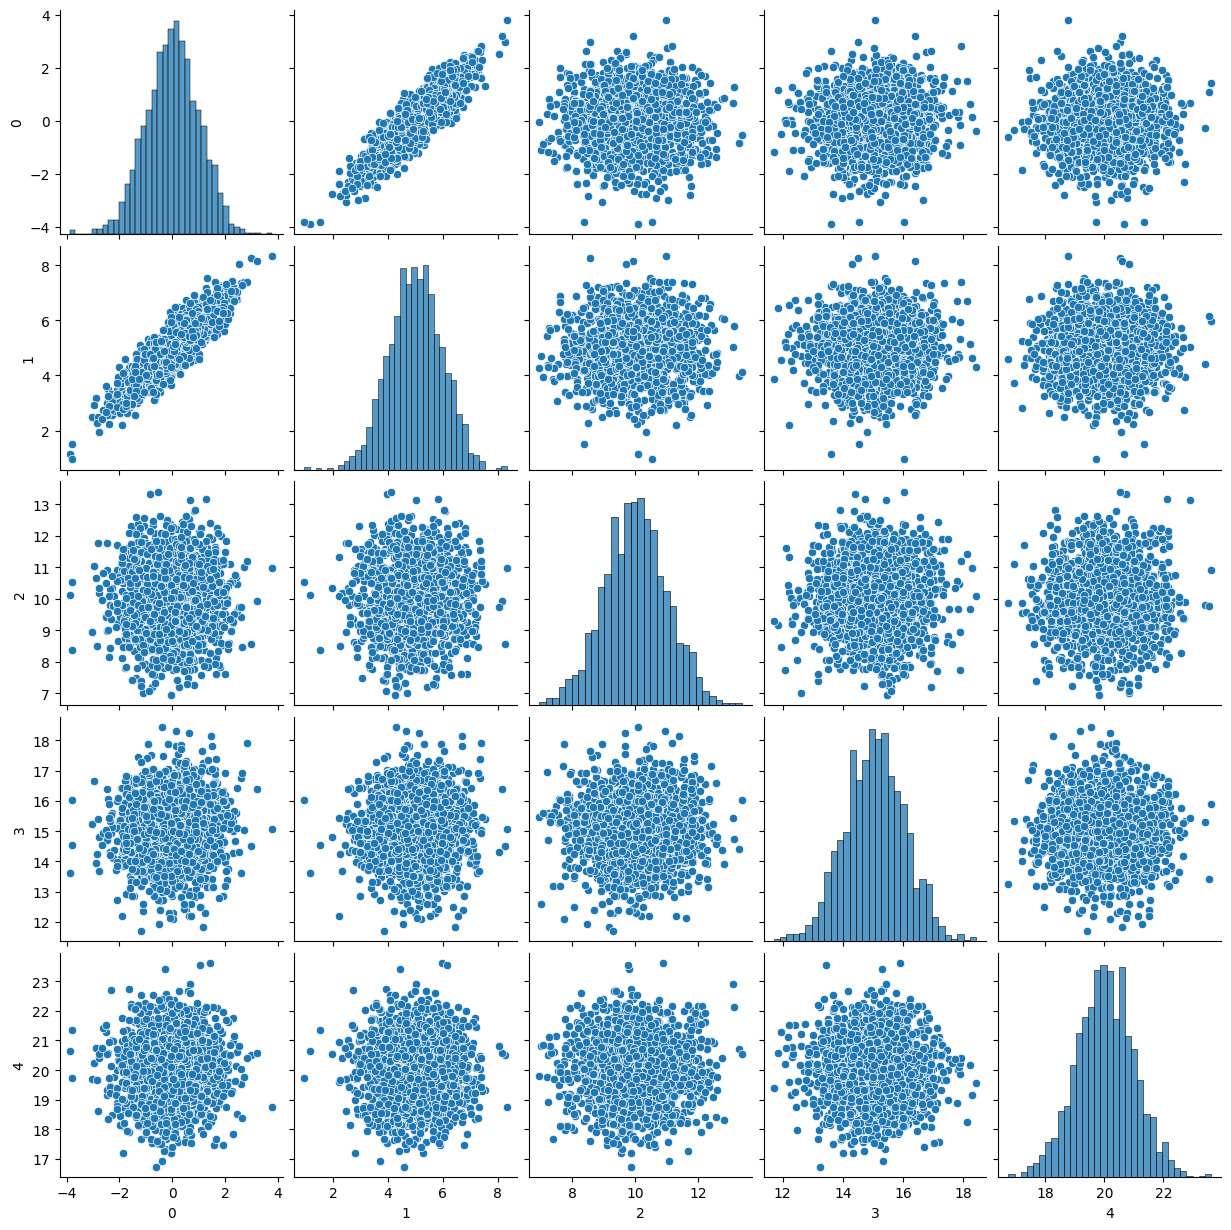

In [21]:
sns.pairplot(df)

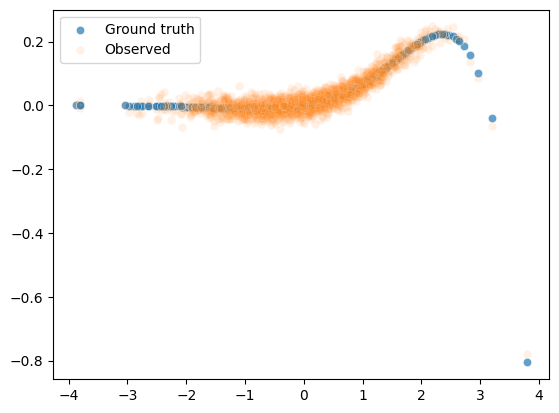

In [22]:
# only uses one variable
target_clean = 1.e-1 * np.exp(samples[:, 0]) * 0.3 * np.sin(samples[:, 0])
target = target_clean + .02 * np.random.normal(0, 1, size=len(target_clean))
sns.scatterplot(x=samples[:, 0], y=target_clean, label="Ground truth", alpha=0.7)
sns.scatterplot(x=samples[:, 0], y=target, label="Observed", alpha=0.1)
plt.legend()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(samples, target, random_state=seed, train_size=0.6)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1200, 5) (1200,)
(800, 5) (800,)


In [24]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('model', KernelRidge(kernel='rbf'))])

In [25]:
print(pipe.score(x_train, y_train))

0.866338137341993


In [26]:
print(pipe.score(x_test, y_test))

0.6182995163480505


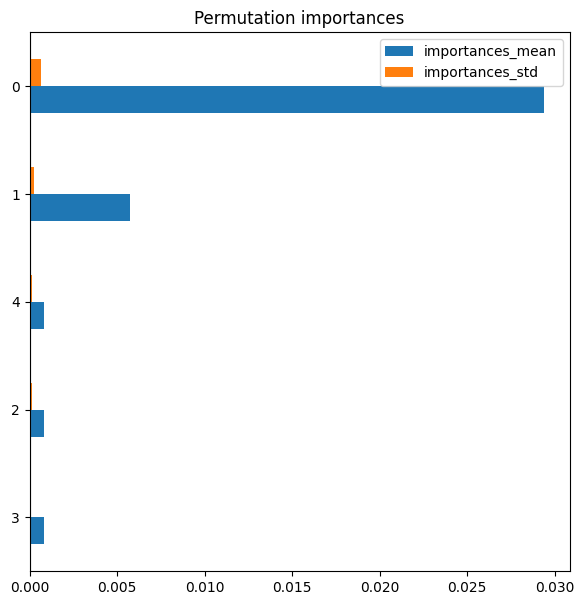

In [27]:
# Now back to obtaining importances
explanation_train = permutation_importance(
    pipe,
    X=x_train,
    y=y_train,
    n_repeats=10,
    random_state=seed,
    scoring=scorer)

plot_explanation(explanation_train)

As can be seen from above, even though the data we simulated depended only on the first feature, the model still assigns quite high importance to the second feature as well due to them being correlated which can lead to wrong conclusions during model interpretation!

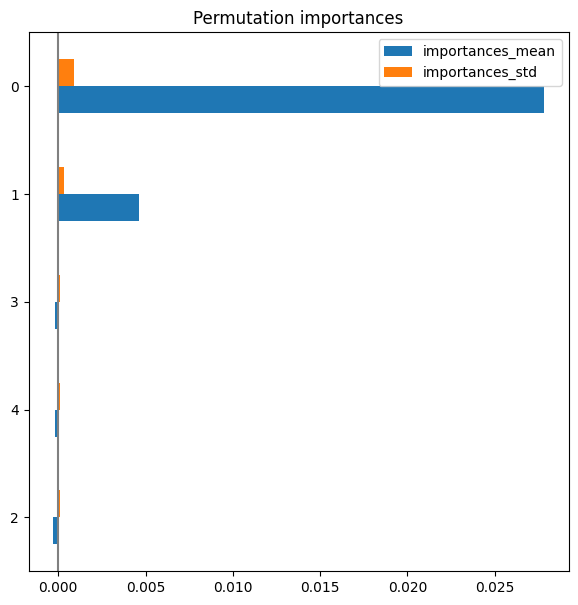

In [28]:
# Now back to obtaining importances
explanation_test = permutation_importance(
    pipe,
    X=x_test,
    y=y_test,
    n_repeats=10,
    random_state=seed,
    scoring=scorer)

plot_explanation(explanation_test)

# Check your learning

1. What is achieved by permuting feature values?
2. Would it also be a good idea to permute the target instead of the features?
3. How should the output of permutation importance for a single feature be interpreted?
4. What does a negative importance value mean?
5. Why don't we leave out a feature instead of permuting it to measure its importance?

<details>
  <summary>Display answers</summary>


1. The existing relation between target and the feature are destroyed by randomly assigning new values to the given labels, making it impossible for the model to draw any conclusion from this feature to predict the label.
2. No since we could not measure an effect for each feature anymore.
3. It is the (average over multiple permutations) decrease of a performance measure compared to a model that did not have the feature permuted.
4. This means that permuting the feature increases the performance of the model. Then it might be advisable to consider removing the feature and to retrain the model.
5. Leaving out the feature would require training a second model with less input features, which then would make the comparison harder.

</details>